In [ ]:
#|default_exp my_fff

In [ ]:
#|hide
import nbdev
import math
import torch.optim as optim
from torch import tensor
from torchvision.datasets import MNIST
from fastai.vision.all import *
from fastai.callback.wandb import *

import FastFF.fff as fff
from FastFF.activations import *
from FastFF.performance import *

In [ ]:
#|export
import torch
import torch.nn as nn, torch.nn.functional as F
from fastcore.all import *

In [ ]:
#|export
class FFF(nn.Module):
    def __init__(self, in_dim, out_dim, depth, act=nn.ReLU, hidden_dim = None):
        super().__init__()
        store_attr()
        self.n_leaves = 2**depth
        self.nodes = nn.Linear(in_dim, self.n_leaves-1)
        self.leaves = nn.Linear(in_dim, ifnone(hidden_dim, out_dim)*self.n_leaves)
        if hidden_dim: self.leaves_out = nn.ModuleList(nn.Linear(hidden_dim, out_dim) for _ in range(self.n_leaves))
        self.act = act() if act else noop
    
    def forward(self, x):
        bs = x.shape[0]
        probs = F.sigmoid(self.nodes(x))  # (bs, n_leaves-1)
        leaf_distr = torch.ones([bs,self.n_leaves]) # (bs, n_leaves)
        for d in range(self.depth):
            layer_probs = probs[:, 2**d-1 : 2**(d+1)-1] # (bs, 2**d)
            mask = torch.stack((1-layer_probs, layer_probs), dim=2).view(bs, -1) # (bs, 2**(d+1) )
            leaf_distr = leaf_distr.view(bs, 2**(d+1), -1) * mask[..., None] # (bs, 2**(d+1), n_leaves//2**(d+1) )
        
        logits = self.act(self.leaves(x)).view(bs,self.n_leaves, -1) # (bs, n_leaves, out_dim)
        if self.hidden_dim: logits =  self.act(torch.stack([self.leaves_out[i](logits[:,i,:]) for i in range(self.n_leaves)], dim=1))
        return torch.bmm(logits.view(bs, -1, self.n_leaves), leaf_distr.view(bs, -1,1)).view(bs, -1)

In [ ]:
x = torch.randn(3,28*28)

In [ ]:
d = 4
m = FFF(28*28, 10, d, act=None, hidden_dim=5)
# m2 = fff.FFF(28*28, 5, 2, d)

In [ ]:
# m.nodes.weight = m2.node_weights
# m.nodes.bias = nn.Parameter(m2.node_biases.flatten())
# m.leaves.weight = nn.Parameter(m2.w1s.transpose(0, 1).flatten(1, 2).T)
# m.leaves.bias = nn.Parameter(m2.b1s.flatten())
# for i, mod in enumerate(m.leaves_out):
#     mod.weight = nn.Parameter(m2.w2s.view(2**d, 2, -1)[i])
#     mod.bias = nn.Parameter(m2.b2s[i])

In [ ]:
#|hide
mean, std = 0.130652368068695068, 0.307504087686538696

tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)),
                 T.Lambda(lambda x: x.view(-1,28*28).squeeze())])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)

In [ ]:
d = 3
l = 128
bs = 256

In [ ]:
#|hide
#|eval: false
model_fff = FFF(28*28, 10, d, act=nn.GELU, hidden_dim=128)
dls = DataLoaders(TfmdDL(train_dataset, bs, True),TfmdDL(test_dataset, bs, False))
cbs = [FFFLeavesDistCB(False, model_fff, 40), GetGradCB()]
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=3e-2);

epoch,train_loss,valid_loss,accuracy,time


AttributeError: Exception occured in `GetGradCB` when calling event `after_backward`:
	'FFF' object has no attribute 'w1s'

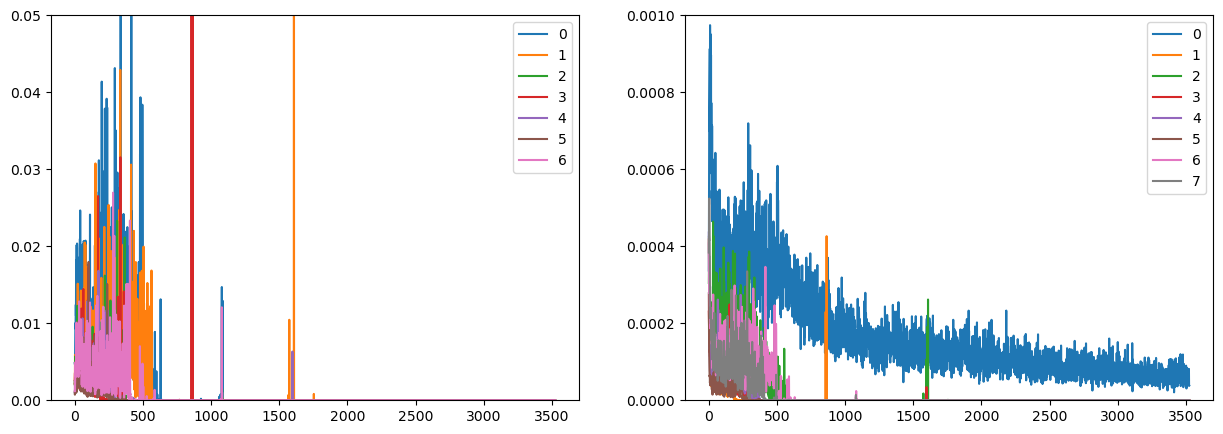

In [ ]:
axes = subplots(figsize=(15,5), ncols=2)[1]
axes[0].set_ylim(0.0,0.05); axes[1].set_ylim(0.0,0.001)

cbs[1].show(ax=axes[0])
cbs[1].show(True, ax=axes[1])